In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import torch
import re
from my_utils_v2 import *


In [52]:
tissue_path='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA020TIB/Registered'
tissue_name='GCA020TIB_TISSUE01'
mask_path=f'/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA020TIB/Registered/{tissue_name}_RetentionMask.tif'

In [53]:
file_names = os.listdir(tissue_path)

# Filter the list to only include files named {tissue_name}_DAPI
dapi_files = [file for file in file_names if f'{tissue_name}_DAPI' in file]

In [54]:
dapi_files_sorted = sorted(dapi_files, key=lambda file: int(re.search('ROUND_(\\d+)', file).group(1)))

In [55]:
dapi_files_sorted

['GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_00.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_01.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_02.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_03.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_04.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_05.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_06.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_07.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_08.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_09.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_10.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_11.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_12.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_13.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_14.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_15.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_16.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_17.tif',
 'GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_18.tif']

In [56]:
round0_dapi_for_composition=os.path.join(tissue_path,dapi_files_sorted[0])
round_last_dapi_for_composition=os.path.join(tissue_path,dapi_files_sorted[-1])
Retention_Mask=np.array(Image.open(mask_path))

block_size = 1024

round0_dapi_for_composition=np.array(Image.open(round0_dapi_for_composition)) / 255.
round_last_dapi_for_compositin=np.array(Image.open(round_last_dapi_for_composition)) /255.
round0_dapi_for_composition = round0_dapi_for_composition * Retention_Mask
round_last_dapi_for_compositin = round_last_dapi_for_compositin * Retention_Mask
original_height, original_width = round0_dapi_for_composition.shape

pad_size0 = block_size - round0_dapi_for_composition.shape[0] % block_size
pad_size1 = block_size - round0_dapi_for_composition.shape[1] % block_size

# Pad the images
round0_dapi_for_composition = np.pad(round0_dapi_for_composition, ((0, pad_size0), (0, pad_size1)))
round_last_dapi_for_compositin = np.pad(round_last_dapi_for_compositin, ((0, pad_size0), (0, pad_size1)))

model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_1_epochs/epoch_15/epoch_15.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

#L2_norm=Utils_v2.L2_norm_mask(round0_dapi_for_composition,round_last_dapi_for_compositin,model,device)

In [40]:
mask = L2_norm > 5

mask_image = (mask * 255).astype(np.uint8)

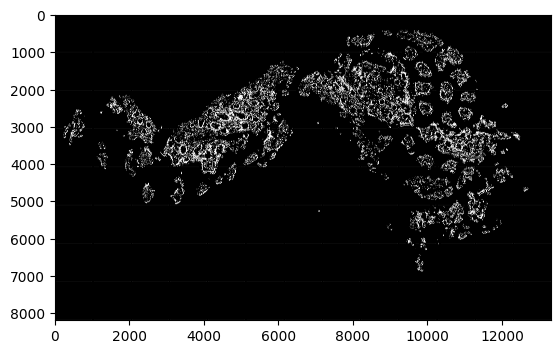

In [41]:
plt.imshow(mask_image,cmap='gray')

In [42]:
np.unique(mask_image)

array([  0, 255], dtype=uint8)

In [43]:
#round0_dapi_for_composition[mask_image == 255] = 0

In [57]:
def get_norm_field(moving, fixed, model, device):
    block_size = (1024, 1024)
    moving_tissue_blocks = view_as_blocks(moving, block_shape=block_size)
    fixed_tissue_blocks = view_as_blocks(fixed, block_shape=block_size)
    pred_blocks_field=[]

    for i in range(moving_tissue_blocks.shape[0]):
        row_blocks_field = []
        for j in range(moving_tissue_blocks.shape[1]):
            moving_block = moving_tissue_blocks[i, j]
            fixed_block = fixed_tissue_blocks[i, j]
            moving_block = moving_block[np.newaxis, ..., np.newaxis]
            fixed_block = fixed_block[np.newaxis, ..., np.newaxis]
            moving_block = torch.from_numpy(moving_block).to(device).float().permute(0,3,1,2)
            fixed_block = torch.from_numpy(fixed_block).to(device).float().permute(0,3,1,2)
            _,fwd_pred = model(moving_block,fixed_block ,registration=True)
            warp_field=fwd_pred.cpu().detach().numpy().squeeze()
            L2_norm = np.sqrt(warp_field[0]**2 + warp_field[1]**2)
            row_blocks_field.append(L2_norm)
        pred_blocks_field.append(row_blocks_field)

    composed_warp = np.block(pred_blocks_field)
    return composed_warp    

In [58]:
field_magnitudes = []
from tqdm import tqdm
# Loop over all files
for file in tqdm(dapi_files_sorted[1:]):
    # Open the image file and normalize it
    tissue = np.array(Image.open(os.path.join(tissue_path, file))) / 255.
    tissue = tissue * Retention_Mask
    # Pad the image
    tissue = np.pad(tissue, ((0, pad_size0), (0, pad_size1)))

    # Apply the mask
  #  tissue[mask_image == 255] = 0

    # Calculate the field magnitude
    field_magnitude = get_norm_field(tissue, round0_dapi_for_composition, model, device)

    # Add the field magnitude to the list
    field_magnitudes.append(field_magnitude)

# Convert the list to a NumPy array
field_magnitudes = np.array(field_magnitudes)

100%|██████████| 18/18 [01:17<00:00,  4.32s/it]


In [46]:
field_magnitudes.shape

(18, 8192, 13312)

In [59]:
pixel_wise_mean = np.mean(field_magnitudes, axis=0)
pixel_wise_std = np.std(field_magnitudes, axis=0)

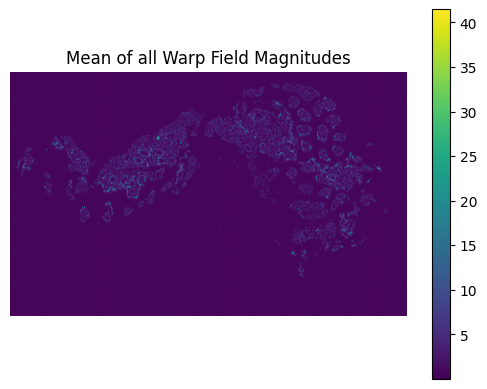

In [60]:
plt.figure()

# Display the L2 norm
plt.imshow(pixel_wise_mean, cmap='viridis',vmax=10)

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('Mean of all Warp Field Magnitudes')
plt.axis('off')
# Show the plot
plt.show()

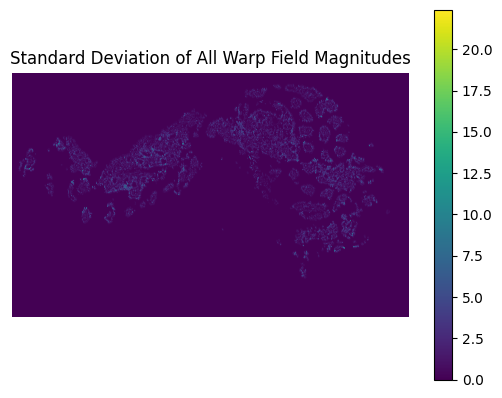

In [61]:
plt.figure()

# Display the L2 norm
plt.imshow(pixel_wise_std, cmap='viridis')

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('Standard Deviation of All Warp Field Magnitudes')
plt.axis('off')
# Show the plot
plt.show()

In [46]:
tissue=np.array(Image.open(os.path.join(tissue_path,dapi_files_sorted[17])))/255.
tissue = np.pad(tissue, ((0, pad_size0), (0, pad_size1)))
tissue[mask_image == 255] = 0

In [48]:
field_magnitude= get_norm_field(tissue,round0_dapi_for_composition,model,device)

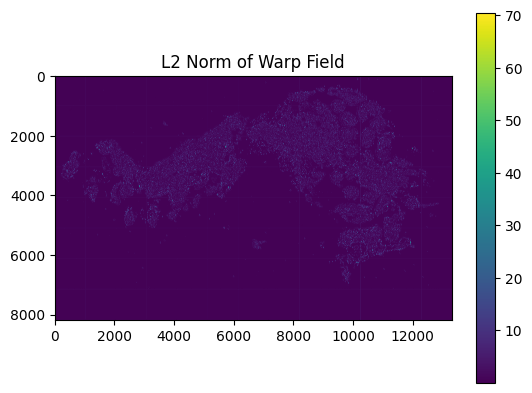

In [49]:
plt.figure()

# Display the L2 norm
plt.imshow(field_magnitude, cmap='viridis')

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('L2 Norm of Warp Field')

# Show the plot
plt.show()

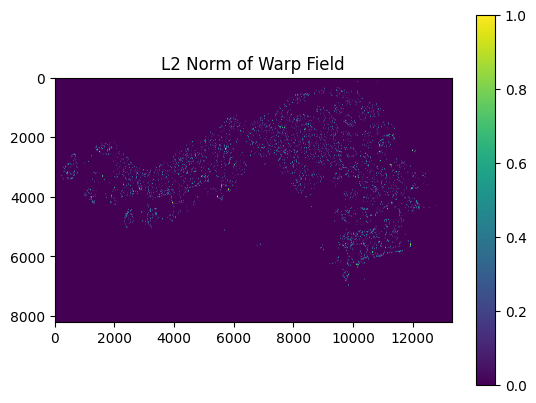

In [50]:
field_magnitude_mask=field_magnitude>10
plt.imshow(field_magnitude_mask, cmap='viridis')

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('L2 Norm of Warp Field')

# Show the plot
plt.show()